# Autoencoder Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
from collections import Counter
import ast

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist

## Data Preparation

In [2]:
df_books = pd.read_csv('books_autorec.csv')
df_books.sort_values(by='ratings_count', ascending=False, inplace=True)
Books_number = 2000
df_books = df_books.iloc[:Books_number]
df_books['goodreads_book_id'] = df_books['goodreads_book_id'].astype(int)
book_ids = df_books['goodreads_book_id']

In [3]:
df = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

modified_df_ratings = df_ratings.merge(
    df[['goodreads_book_id']], 
    left_on='book_id', 
    right_on='goodreads_book_id', 
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in modified_df_ratings.groupby('user_id'):
    modified_books_ratings = group[['book_id', 'rating']].values.tolist()
    sparse_users[user_id] = modified_books_ratings

filter_users = {
    user: [triplet for triplet in triplets if triplet[0] in book_ids]
    for user, triplets in sparse_users.items()
}
filter_users = {user: triplets for user, triplets in filter_users.items() if triplets}
#user taken
taken_users = 50000
filter_users = sorted(filter_users.items(), key=lambda x: len(x[1]), reverse=True)[:taken_users]
filter_users = dict(filter_users)

In [4]:
mapping_pos_to_books = dict(zip(range(Books_number), book_ids))
mapping_books_to_pos = dict(zip(book_ids,range(Books_number)))
mapping_pos_to_users = dict(zip(range(taken_users), filter_users.keys()))
mapping_users_to_pos = dict(zip(filter_users.keys(),range(taken_users)))

In [5]:
n_books = len(mapping_books_to_pos)
user_vectors = []
for user_id, book_rating in filter_users.items():
    vector = np.zeros(n_books)  # initialize vector with zeros

    for book_id, rating in book_rating:
        if book_id in mapping_books_to_pos:  # if book_id is in the mapping
            index = mapping_books_to_pos[book_id]
            vector[index] = rating  # insert rating in the correct position

    user_vectors.append(vector)
    
print("Number of Users", len(user_vectors))
print("Number of Books", len(user_vectors[0]))
for i in range(len(user_vectors)):
    user_vectors[i] = [0 if elem < 3 else 1 for elem in user_vectors[i]]
print("Example of a user: ", user_vectors[0][:20])
df_input_data = pd.DataFrame(user_vectors)

Number of Users 48939
Number of Books 2000
Example of a user:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


## Clustering

In [6]:
def string_to_list(stringa):
    lista = [elemento.strip() for elemento in stringa.split(",")]
    for i, element in enumerate(lista):
        lista[i] = element.strip('[').strip(']').strip('\'')
    return lista

df_books['tags_list'] = df_books['tags_list'].apply(string_to_list)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_books['tags_string'])

In [8]:
from sklearn.cluster import KMeans

k = 8
kmeans_model = KMeans(n_clusters=k, random_state=3, max_iter=1000, n_init=10)
df_books['cluster'] = kmeans_model.fit_predict(X)

In [9]:
cluster_counts = df_books['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} elements")

Cluster 0: 247 elements
Cluster 1: 264 elements
Cluster 2: 318 elements
Cluster 3: 157 elements
Cluster 4: 269 elements
Cluster 5: 474 elements
Cluster 6: 56 elements
Cluster 7: 215 elements


In [10]:
def print_top_tags_per_cluster(df, top_n=20):

    for cluster_id in sorted(df['cluster'].unique()):
        tags = df[df['cluster'] == cluster_id]['tags_list'].explode()
        tag_counts = Counter(tags)
        most_common = tag_counts.most_common(top_n)
        print(f"\nCluster {cluster_id}:")
        for tag, count in most_common:
            print(f"  {tag}")

In [11]:
print_top_tags_per_cluster(df_books, top_n=10)


Cluster 0:
  sci-fi-fantasy
  fantasy
  favorites
  fiction
  books-i-own
  currently-reading
  library
  owned
  owned-books
  favourites

Cluster 1:
  owned
  owned-books
  books-i-own
  library
  currently-reading
  to-buy
  favorites
  default
  my-library
  non-fiction

Cluster 2:
  fantasy
  owned
  fiction
  books-i-own
  favorites
  i-own
  currently-reading
  library
  series
  favourites

Cluster 3:
  mystery
  favorites
  mystery-thriller
  kindle
  ebook
  fiction
  books-i-own
  owned-books
  currently-reading
  thriller

Cluster 4:
  fiction
  favorites
  literature
  books-i-own
  owned
  my-books
  to-buy
  default
  adult
  my-library

Cluster 5:
  favorites
  fiction
  owned
  books-i-own
  currently-reading
  owned-books
  library
  contemporary
  kindle
  to-buy

Cluster 6:
  fiction
  owned
  library
  my-library
  fantasy
  suspense
  adult
  my-books
  ebooks
  currently-reading

Cluster 7:
  children-s
  children-s-lit
  favorites
  kids-books
  fiction
  child

## Training

In [12]:
class Spatial_F_AE(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,50),
            nn.ReLU(),
            nn.Linear(50,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

In [13]:
def train(model, dataloader, criterion, optimizer, num_epochs, scheduler=None, best_loss=float('inf')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs = batch[0]
            inputs = inputs.to(device)
            recon = model(inputs)
            loss = criterion(recon, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step(loss.item())
            running_loss += loss.item()
        losses.append(running_loss / (i + 1))
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Loss = {running_loss / (i + 1):.10f}")
    return losses

In [14]:
def loss_graph(tr_loss,n_epochs):
    plt.plot(range(n_epochs),tr_loss,label='tr_loss', c='black')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

In [15]:
tensor_data = torch.tensor(df_input_data.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(tensor_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
model = Spatial_F_AE(Books_number)

It the model is already trained and you see the best_model.pth file in the repository you can avoid retraining and run the followinc cell to sideload the weights of the model

In [16]:
# model.load_state_dict(torch.load('best_model.pth'))

Actual train of the model:

Epoch 1: Loss = 0.0044543960
Epoch 2: Loss = 0.0030503899
Epoch 3: Loss = 0.0030501267
Epoch 4: Loss = 0.0030494922
Epoch 5: Loss = 0.0030496693
Epoch 6: Loss = 0.0030487959
Epoch 7: Loss = 0.0030483381
Epoch 8: Loss = 0.0030483136
Epoch 9: Loss = 0.0030485133
Epoch 10: Loss = 0.0030476742
Epoch 11: Loss = 0.0030480432
Epoch 12: Loss = 0.0030473403
Epoch 13: Loss = 0.0030466958
Epoch 14: Loss = 0.0030466362
Epoch 15: Loss = 0.0030466372
Epoch 16: Loss = 0.0030460878
Epoch 17: Loss = 0.0030462569
Epoch 18: Loss = 0.0030460548
Epoch 19: Loss = 0.0030461519
Epoch 20: Loss = 0.0030453626


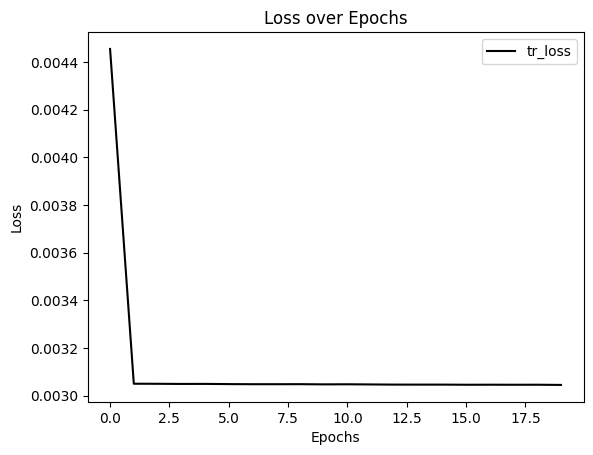

In [17]:
criterion = nn.MSELoss()
N_Epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False)

losses = train(model,dataloader,criterion, optimizer, N_Epochs, scheduler)
loss_graph(losses, N_Epochs)

## Find Recommendations

In [18]:
def recommendations(user, model, n=25):
    model.eval()
    recon = model(user)
    old_books= (user != 0).nonzero(as_tuple=True)[0].tolist()
    _, new_books = torch.topk(recon, n) # top recommendations
    new_books = new_books.tolist()
    old_books_map = [mapping_pos_to_books[pos] for pos in old_books]
    new_books_map = [mapping_pos_to_books[pos] for pos in new_books]
    old_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in old_books_map]
    new_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in new_books_map]
    diff = list(set(new_titles) - set(old_titles))
    diff_id = list(set(new_books_map) - set(old_books_map))
    return diff, diff_id, old_books_map

In [19]:
def print_recommendations(user, n=25):
    if isinstance(user, int):
        rec, rec_id, old_id = recommendations(dataloader.dataset[user][0], model, n)
    else:
        rec, rec_id, old_id = recommendations(user, model, n)

    print("#############################################\n")
    print(f"Top {n} recommendations for user {user}\n")
    [print(i) for i in rec]
    print("\n#############################################")

## Generate new user

In [32]:
n_best_books_for_cluster = 2
min_n_chosen = 3

def find_bestbooks(n_best_books_for_cluster=n_best_books_for_cluster):
    books = []
    for cluster in df_books['cluster'].unique():
        top_books = df_books[df_books['cluster'] == cluster].nlargest(n_best_books_for_cluster, 'work_ratings_count')
        books.extend(top_books['goodreads_book_id'].tolist())
    return books

def user_from_ids(books_ids):
    user_preferences = np.zeros(n_books)
    for book_id in books_ids:
        if book_id in mapping_books_to_pos:
            user_preferences[mapping_books_to_pos[book_id]] = 1
    return torch.tensor(user_preferences, dtype=torch.float32)

In [45]:
print(f"Choose more than {min_n_chosen} books from the following list:\n")
book_ids = find_bestbooks()
ids = []
for i, book in enumerate(book_ids):
    print(f"{i + 1}. {df_books[df_books['goodreads_book_id'] == book]['title'].values[0]}")
    ids.append(book)

chosen_books = input("\nEnter numbers separated by commas: ")
chosen_books = [int(x) for x in chosen_books.split(",")]
chosen_ids = []

for element in chosen_books:
    chosen_ids.append(ids[element - 1])
    print (f"Chosen book: {df_books[df_books['goodreads_book_id'] == chosen_ids[-1]]['title'].values[0]}")

Choose more than 3 books from the following list:

1. The Hunger Games (The Hunger Games, #1)
2. Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
3. To Kill a Mockingbird
4. The Great Gatsby
5. The Fault in Our Stars
6. The Kite Runner
7. The Hobbit
8. The Fellowship of the Ring (The Lord of the Rings, #1)
9. Angels & Demons  (Robert Langdon, #1)
10. The Girl with the Dragon Tattoo (Millennium, #1)
11. The Diary of a Young Girl
12. Eat, Pray, Love
13. The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1)
14. The Giver (The Giver, #1)
15. The Shining (The Shining #1)
16. It
Chosen book: It
Chosen book: The Shining (The Shining #1)
Chosen book: The Giver (The Giver, #1)


In [46]:
if len(chosen_books) < min_n_chosen:
    print(f"Please choose at least {min_n_chosen} books.")
else:
    print_recommendations(user_from_ids(chosen_ids), n=5)

#############################################

Top 5 recommendations for user tensor([0., 0., 0.,  ..., 0., 0., 0.])

Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Pride and Prejudice
Harry Potter and the Goblet of Fire (Harry Potter, #4)
The Fellowship of the Ring (The Lord of the Rings, #1)

#############################################


## Evaluating

In [26]:
def user_refinding(model,user):
    rating_pos = user[user == 1.0]
    if len(rating_pos) != 0:
        removed_pos = rating_pos[:int(len(rating_pos)/5)+1]
        removed_books = [mapping_pos_to_books[elem] for elem in removed_pos.tolist()]
        _, diff_id, _ = recommendations(user, model)
        diff = list(set(removed_books) - set(diff_id))
        return len(diff)/len(removed_books), len(removed_books)
    else:
        return 0,0

In [ ]:
sum = 0
for i in range(len(mapping_users_to_pos)):
    len_ratio, _ = user_refinding(model, dataloader.dataset[i][0])
    sum += len_ratio
print('On avg we refind: ', sum/len(mapping_users_to_pos), "% of the removed items")

## Example of use

In [27]:
print_recommendations(678, 20)

#############################################

Top 20 recommendations for user 678

Harriet the Spy (Harriet the Spy #1)
A Court of Mist and Fury (A Court of Thorns and Roses, #2)
The Woman in White
Inheritance (The Inheritance Cycle, #4)
Shadow of the Hegemon (Ender's Shadow, #2)
The Good Earth (House of Earth, #1)
Requiem (Delirium, #3)
Of Mice and Men
The Curious Incident of the Dog in the Night-Time
The Fellowship of the Ring (The Lord of the Rings, #1)
The Man in the Brown Suit
The Da Vinci Code (Robert Langdon, #2)
Memoirs of a Geisha
Winnie-the-Pooh (Winnie-the-Pooh, #1)

#############################################
